In [1]:
# This network is used to convert the initial conditions and 
# forcing from the tropical Pacific LES used in Whitt et al., 
# 2022 "Simulation and Scaling of the Turbulent Vertical Heat 
# Transport and Deep-Cycle Turbulence across the Equatorial 
# Pacific Cold Tongue" into a format suitable for use in MOM6.
# (doi: 10.1175/JPO-D-21-0153.1, hereafter W22)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
#import sys
import gsw as gsw


In [3]:
#Valid options are '0' or '3'
Lat = '0'
#Lat = '3'

In [4]:
# The ROMS data location is obtained following instructions in W22
data_loc = '/net/bgr/Work/Tropics_Paper/Paper/'
ROMS = xr.open_dataset(data_loc+'Data/ocean_sta_tpos20_3_d2_2_'+Lat+'N140W.nc')

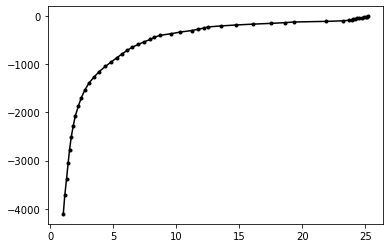

In [5]:
S_rho = (ROMS.hc * ROMS.s_rho + ROMS.Cs_r * ROMS.h) / (ROMS.hc + ROMS.h)
z_rho = ROMS.zeta + (ROMS.zeta + ROMS.h) * S_rho
ZRoms = z_rho.isel(ocean_time=0).values.squeeze()
plt.plot(ROMS.temp.isel(ocean_time=6).squeeze(),ZRoms,'k.-')


In [6]:
# This cell pulls the ROMS output used from W22
# to give an initial condition (for T, S, U, and V) suitable for use in MOM6.
# We map directly to the anticipated model grid because it is easier to
# initialize velocity on the model grid.

MDL_Z = np.arange(0.25,108,0.5)


DS = xr.Dataset()
DS['lat'] = np.array([-90.0,90.0])
DS['lon'] = np.array([-180.0,180.0])
DS['latu'] = np.array([0.,1.,2.])
DS['lonu'] = np.array([0.,1.,2.,3.])
DS['latv'] = np.array([0.,1.,2.,3.])
DS['lonv'] = np.array([0.,1.,2.])
DS['depth'] = MDL_Z
DS['time'] = [0.,]
TEMP1 = np.zeros([1,DS.depth.size,2,2,])
TEMP2 = np.zeros([1,DS.depth.size,2,2,])
TEMP3 = np.zeros([DS.depth.size,3,4,])
TEMP4 = np.zeros([DS.depth.size,4,3,])
for ii in range(2):
    for jj in range(2):
        TEMP1[0,:,ii,jj] = np.interp(MDL_Z,-ZRoms[::-1],ROMS.temp.isel(ocean_time=6).values.squeeze()[::-1])
DS['temp'] = (('time','depth','lat','lon'),TEMP1)
for ii in range(2):
    for jj in range(2):
        TEMP2[0,:,ii,jj] = np.interp(MDL_Z,-ZRoms[::-1],ROMS.salt.isel(ocean_time=6).values.squeeze()[::-1])
DS['salt'] = (('time','depth','lon','lat'),TEMP2)
for jj in range(3):
    for ii in range(4):
        TEMP3[:,jj,ii] = np.interp(MDL_Z,-ZRoms[::-1],ROMS.u.isel(ocean_time=6).values.squeeze()[::-1])
DS['U'] = (('depth','latu','lonu'),TEMP3)
for jj in range(4):
    for ii in range(3):
        TEMP4[:,jj,ii] = np.interp(MDL_Z,-ZRoms[::-1],ROMS.v.isel(ocean_time=6).values.squeeze()[::-1])
DS['V'] = (('depth','latv','lonv'),TEMP4)



DS.to_netcdf('../Data/DW_init_'+Lat+'.nc',
            encoding={'temp': {'dtype': 'double', '_FillValue': -9999},
                     'salt': {'dtype': 'double', '_FillValue': -9999},
                     'U': {'dtype': 'double', '_FillValue': -9999},
                     'V': {'dtype': 'double', '_FillValue': -9999}})

In [7]:
#The LES data is obtained following instructions in W22
LES = xr.open_dataset(data_loc+'/Data/ROMS_PSH_6HRLIN_'+Lat+'N140W_360x360x216_22OCT2020.nc').isel(z=slice(0,215))
LES

<xarray.Dataset>
Dimensions:       (z: 215, time: 8774)
Coordinates:
  * z             (z) float64 -107.5 -107.0 -106.5 -106.0 ... -1.5 -1.0 -0.5
  * time          (time) datetime64[ns] 1985-10-02T06:00:00 ... 1985-11-05T20...
Data variables: (12/41)
    ume           (time, z) float32 ...
    vme           (time, z) float32 ...
    tempme        (time, z) float32 ...
    saltme        (time, z) float32 ...
    urms          (time, z) float32 ...
    vrms          (time, z) float32 ...
    ...            ...
    kappadtdzbot  (time) float32 ...
    alpha         float64 ...
    beta          float64 ...
    T0            float64 ...
    S0            float64 ...
    rho0          float64 ...
Attributes:
    type:     DIABLO LES, processed means
    title:    ROMS_PSH_6HRLIN_0N140W_360x360x216_22OCT2020

In [8]:
# This cell pulls the LES column tendencies used from the W22 tropical LES study
# to give the state variable tendencies suitable for use in MOM6.
# We map directly to the anticipated model grid because it is easier to
# read in data on the model grid (the model can easily handle time interpolation).
#
# This cell includes the solar heating in the forcing, making it easier to be directly identical to
# their original study.

MDL_Z = np.arange(0.25,108,0.5)


DS = xr.Dataset()
DS['lat'] = np.array([-90.0,0.,90.0])
DS['lon'] = np.array([-180.0,0.,180.0])
DS['depth'] = MDL_Z
DS['time'] = LES.time.values.astype('datetime64[s]')
#DS.time.encoding['calendar']='gregorian'


TEMP1 = np.zeros([LES.time.size,DS.depth.size,3,3,])
TEMP2 = np.zeros([LES.time.size,DS.depth.size,3,3,])
TEMP3 = np.zeros([LES.time.size,DS.depth.size,3,3,])
TEMP4 = np.zeros([LES.time.size,DS.depth.size,3,3,])

for ti in range(LES.time.size):
    for ii in range(3):
        for jj in range(3):
            TEMP1[ti,:-1,ii,jj] = LES.dTdtFORCE.isel(time=ti).values.squeeze()[::-1]+LES.dTdtSOLAR.isel(time=ti).values.squeeze()[::-1]
DS['dTdt'] = (('time','depth','lat','lon'),TEMP1)

for ii in range(3):
    for jj in range(3):
        TEMP2[:,:-1,ii,jj] = 0.0
DS['dSdt'] = (('time','depth','lat','lon'),TEMP2)

for ti in range(LES.time.size):
    for ii in range(3):
        for jj in range(3):
            TEMP3[ti,:-1,ii,jj] = LES.dUdtFORCE.isel(time=ti).values.squeeze()[::-1]
DS['dUdt'] = (('time','depth','lat','lon'),TEMP3)

for ti in range(LES.time.size):
    for ii in range(3):
        for jj in range(3):
            TEMP4[ti,:-1,ii,jj] = LES.dVdtFORCE.isel(time=ti).values.squeeze()[::-1]
DS['dVdt'] = (('time','depth','lat','lon'),TEMP4)



DS.to_netcdf('../Data/DW_tend_with_solar_'+Lat+'.nc',
            encoding={
                'time': {'dtype': 'double', '_FillValue': -9999,'calendar':'gregorian'},
                'lon': {'dtype': 'double', '_FillValue': -9999},
                'lat': {'dtype': 'double', '_FillValue': -9999},
                'depth': {'dtype': 'double', '_FillValue': -9999},
                'dTdt': {'dtype': 'double', '_FillValue': -9999},
                'dSdt': {'dtype': 'double', '_FillValue': -9999},
                'dUdt': {'dtype': 'double', '_FillValue': -9999},
                'dVdt': {'dtype': 'double', '_FillValue': -9999}},
             unlimited_dims=['time',])

In [9]:
# This cell pulls the LES column tendencies used from the W22 tropical LES study
# to give the state variable tendencies suitable for use in MOM6.
# We map directly to the anticipated model grid because it is easier to
# read in data on the model grid (the model can easily handle time interpolation).
#
# This cell excludes the solar heating in the forcing, making it easier to use in MOM6 where the
# net surface buoyancy flux (including solar) is relavent in the behavior of some parameterizations.
# In this case it is important to use the JRA55 solar heating in MOM6, and an appropriate
# vertical shortwave attenuation function.

MDL_Z = np.arange(0.25,108,0.5)


DS = xr.Dataset()
DS['lat'] = np.array([-90.0,0.,90.0])
DS['lon'] = np.array([-180.0,0.,180.0])
DS['depth'] = MDL_Z
DS['time'] = LES.time.values.astype('datetime64[s]')
#DS.time.encoding['calendar']='gregorian'


TEMP1 = np.zeros([LES.time.size,DS.depth.size,3,3,])
TEMP2 = np.zeros([LES.time.size,DS.depth.size,3,3,])
TEMP3 = np.zeros([LES.time.size,DS.depth.size,3,3,])
TEMP4 = np.zeros([LES.time.size,DS.depth.size,3,3,])

for ti in range(LES.time.size):
    for ii in range(3):
        for jj in range(3):
            TEMP1[ti,:-1,ii,jj] = LES.dTdtFORCE.isel(time=ti).values.squeeze()[::-1]
DS['dTdt'] = (('time','depth','lat','lon'),TEMP1)

for ii in range(3):
    for jj in range(3):
        TEMP2[:,:-1,ii,jj] = 0.0
DS['dSdt'] = (('time','depth','lat','lon'),TEMP2)

for ti in range(LES.time.size):
    for ii in range(3):
        for jj in range(3):
            TEMP3[ti,:-1,ii,jj] = LES.dUdtFORCE.isel(time=ti).values.squeeze()[::-1]
DS['dUdt'] = (('time','depth','lat','lon'),TEMP3)

for ti in range(LES.time.size):
    for ii in range(3):
        for jj in range(3):
            TEMP4[ti,:-1,ii,jj] = LES.dVdtFORCE.isel(time=ti).values.squeeze()[::-1]
DS['dVdt'] = (('time','depth','lat','lon'),TEMP4)



DS.to_netcdf('../Data/DW_tend_without_solar_'+Lat+'.nc',
            encoding={
                'time': {'dtype': 'double', '_FillValue': -9999,'calendar':'gregorian'},
                'lon': {'dtype': 'double', '_FillValue': -9999},
                'lat': {'dtype': 'double', '_FillValue': -9999},
                'depth': {'dtype': 'double', '_FillValue': -9999},
                'dTdt': {'dtype': 'double', '_FillValue': -9999},
                'dSdt': {'dtype': 'double', '_FillValue': -9999},
                'dUdt': {'dtype': 'double', '_FillValue': -9999},
                'dVdt': {'dtype': 'double', '_FillValue': -9999}},
             unlimited_dims=['time',])

In [10]:
# This cell pulls the LES surface forcing used from the W22 tropical LES study
# to give the surface boundary conditions suitable for use in MOM6.
#

DS = xr.Dataset()
DS['lat'] = np.array([-90.0,0.,90.0])
DS['lon'] = np.array([-180.0,0.,180.0])
DS['latu'] = np.array([0.,1.,2.])
DS['lonu'] = np.array([0.,1.,2.])
DS['latv'] = np.array([0.,1.,2.])
DS['lonv'] = np.array([0.,1.,2.])
DS['time'] = LES.time.values.astype('datetime64[s]')


TEMP1 = np.zeros([LES.time.size,3,3,])
TEMP2 = np.zeros([LES.time.size,3,3,])
TEMP3 = np.zeros([LES.time.size,3,3,])
TEMP4 = np.zeros([LES.time.size,3,3,])

for ti in range(LES.time.size):
    TEMP1[ti,:,:] = LES.nududztop.isel(time=ti).values.squeeze()*-1025.
    TEMP2[ti,:,:] = LES.nudvdztop.isel(time=ti).values.squeeze()*-1025.
    TEMP3[ti,:,:] = LES.kappadtdztop.isel(time=ti).values.squeeze()*-1025.*3992
    TEMP4[ti,:,:] = LES.kappadsdztop.isel(time=ti).values.squeeze()*-1.
DS['u_flux'] = (('time','latu','lonu'),TEMP1)
DS['v_flux'] = (('time','latv','lonv'),TEMP2)
DS['t_flux'] = (('time','lat','lon'),TEMP3)
DS['salt_flux'] = (('time','lat','lon'),TEMP4)

DS.to_netcdf('../Data/DW_surfflux_'+Lat+'.nc',
            encoding={
                'time': {'dtype': 'double', '_FillValue': -9999,'calendar':'gregorian'},
                'lon': {'dtype': 'double', '_FillValue': -9999},
                'lat': {'dtype': 'double', '_FillValue': -9999},
                'lonu': {'dtype': 'double', '_FillValue': -9999},
                'latu': {'dtype': 'double', '_FillValue': -9999},
                'lonv': {'dtype': 'double', '_FillValue': -9999},
                'latv': {'dtype': 'double', '_FillValue': -9999},
                'u_flux': {'dtype': 'double', '_FillValue': -9999},
                'v_flux': {'dtype': 'double', '_FillValue': -9999},
                't_flux': {'dtype': 'double', '_FillValue': -9999},
                'salt_flux': {'dtype': 'double', '_FillValue': -9999}},
             unlimited_dims=['time',])